## Тестовое задание

**- Постройте модель, предсказывающую, согласится ли клиент взять банковский продукт**

**- Оцените качество полученной модели**

**- Предскажите результат для тестовой выборки** 


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import seaborn as sns
sns.set(font_scale=1.3)

from sklearn import model_selection, metrics, linear_model, ensemble

**Загрузим данные для обучения и посмотрим на них:**

In [2]:
train = pd.read_csv('train.csv')
train.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,30,blue-collar,married,basic.9y,no,yes,no,cellular,may,fri,...,2,999,0,nonexistent,-1.8,92.893,-46.2,1.313,5099.1,no
1,39,services,single,high.school,no,no,no,telephone,may,fri,...,4,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,no
2,25,services,married,high.school,no,yes,no,telephone,jun,wed,...,1,999,0,nonexistent,1.4,94.465,-41.8,4.962,5228.1,no
3,38,services,married,basic.9y,no,unknown,unknown,telephone,jun,fri,...,3,999,0,nonexistent,1.4,94.465,-41.8,4.959,5228.1,no
4,47,admin.,married,university.degree,no,yes,no,cellular,nov,mon,...,1,999,0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8,no


In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3222 entries, 0 to 3221
Data columns (total 21 columns):
age               3222 non-null int64
job               3222 non-null object
marital           3222 non-null object
education         3222 non-null object
default           3222 non-null object
housing           3222 non-null object
loan              3222 non-null object
contact           3222 non-null object
month             3222 non-null object
day_of_week       3222 non-null object
duration          3222 non-null int64
campaign          3222 non-null int64
pdays             3222 non-null int64
previous          3222 non-null int64
poutcome          3222 non-null object
emp.var.rate      3222 non-null float64
cons.price.idx    3222 non-null float64
cons.conf.idx     3222 non-null float64
euribor3m         3222 non-null float64
nr.employed       3222 non-null float64
y                 3222 non-null object
dtypes: float64(5), int64(5), object(11)
memory usage: 528.7+ KB


In [4]:
train.y.value_counts(normalize=True)

no     0.887647
yes    0.112353
Name: y, dtype: float64

**Видим, что в данных нет пропусков; всего 3222 наблюдений, среди которых около 11% соответствуют согласию взять банковский продукт. Выделим количественные и номинативные признаки в переменные `numeric_columns` и `categorial_columns` соответственно:**

In [5]:
numeric_columns = [c for c in train.columns if train[c].dtype=='int64' or train[c].dtype=='float64']
categorial_columns = [c for c in train.columns if train[c].dtype=='object']

**Визуализируем распределение количественных признаков:**

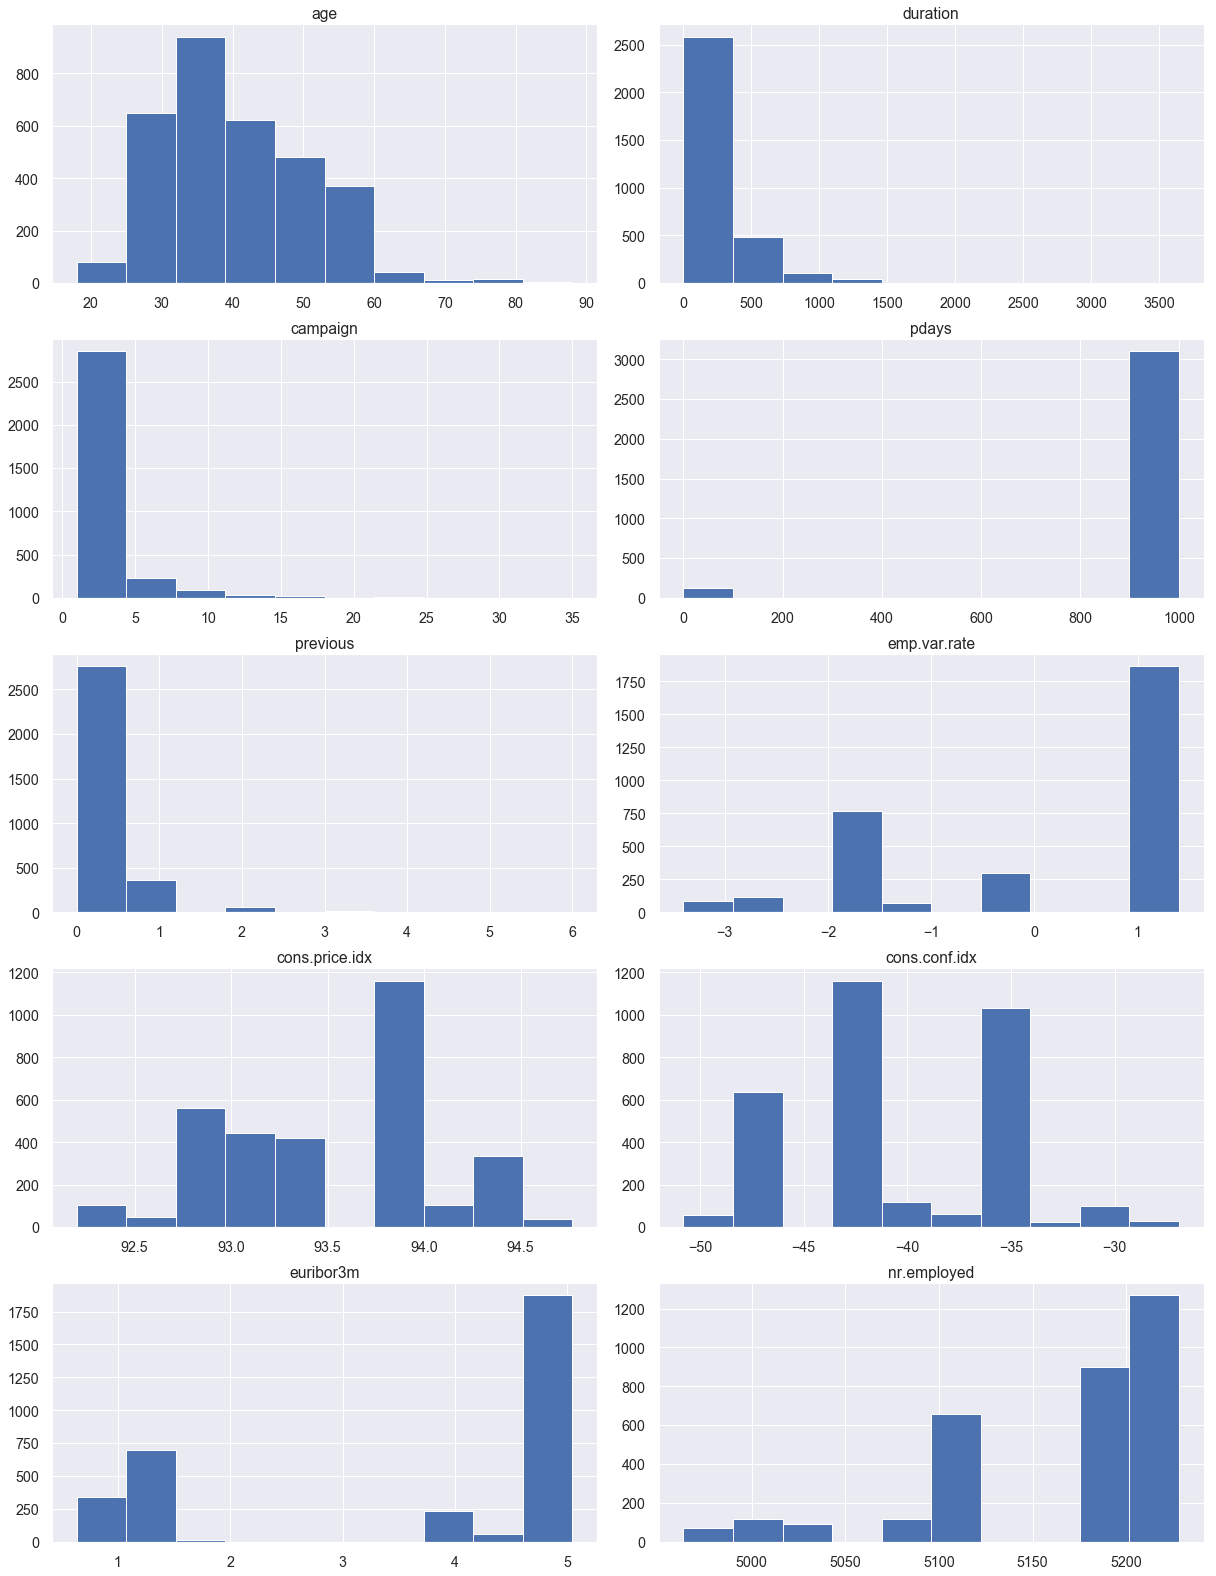

In [6]:
fig, axes = plt.subplots(ncols=2, nrows=5, figsize=(17, 22))

for idx, column in enumerate(numeric_columns):
    axes[idx // 2][idx % 2].hist(train[numeric_columns[idx]])
    axes[idx // 2][idx % 2].set_title(numeric_columns[idx])

fig.tight_layout()

**Видим, что ни один из признаков не распределен нормально. Построим сводную таблицу с помощью `pivot_table` и посмотрим на средние значения в двух группах и также построим таблицу сопряженности для номинативной переменной `month`:**

In [7]:
train.pivot_table(numeric_columns, 'y', aggfunc='mean')

,age,campaign,cons.conf.idx,cons.price.idx,duration,emp.var.rate,euribor3m,nr.employed,pdays,previous
y,,,,,,,,,,
no,39.753497,2.597552,-40.636853,93.601119,215.274476,0.235070,3.790614,5174.927657,984.414336,0.138462
yes,41.494475,1.953039,-40.133149,93.480577,563.439227,-1.041713,2.262138,5097.047790,776.687845,0.607735


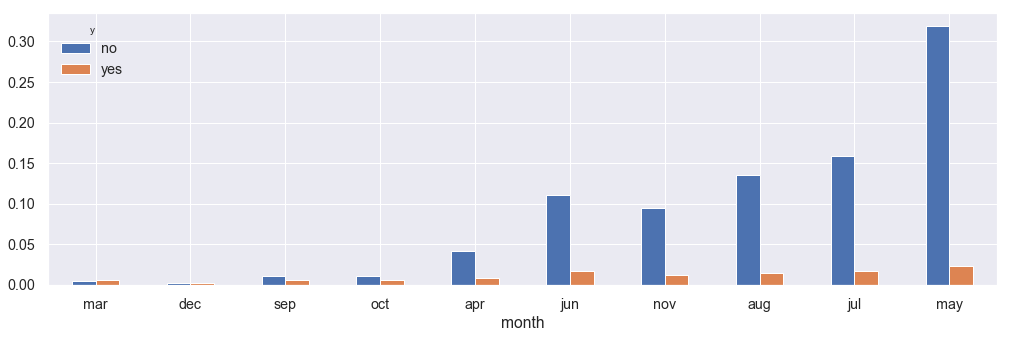

In [8]:
temp_table = pd.crosstab(train.month, train.y, normalize=True)

temp_table['Соотношение'] = temp_table['yes'] / temp_table['no']

temp_table.sort_values(by='Соотношение', ascending=False)[['no', 'yes']].plot(kind='bar', rot=0, figsize=(17, 5))

**Видим, что в среднем возраст `age` выше в группе, в которой согласны взять банковский продукт; схожим образом среднее значение переменной `duration` более чем в два раза выше в группе, в которой согласны взять банковский продукт.**

**По таблице сопряженности можно увидеть, что доля согласных взять банковский продукт очень высока в марте, декабре и сентябре, несмотря на небольшое количество предложений.**

**Закодируем категориальные переменные аналогично LabelEncoder с использованием метода `factorize` и сохраним кодировку в переменную `mapping` - далее она пригодится для кодирования тестовой выборки:**

In [9]:
mapping = {}

for column in categorial_columns:

        labels, uniques = pd.factorize(train[column])
        train[column] = labels

        m = {i: j for i, j in zip(uniques, range(len(uniques)))}
        mapping[column] = m

In [10]:
train.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,30,0,0,0,0,0,0,0,0,0,...,2,999,0,0,-1.8,92.893,-46.2,1.313,5099.1,0
1,39,1,1,1,0,1,0,1,0,0,...,4,999,0,0,1.1,93.994,-36.4,4.855,5191.0,0
2,25,1,0,1,0,0,0,1,1,1,...,1,999,0,0,1.4,94.465,-41.8,4.962,5228.1,0
3,38,1,0,0,0,2,1,1,1,0,...,3,999,0,0,1.4,94.465,-41.8,4.959,5228.1,0
4,47,2,0,2,0,0,0,0,2,2,...,1,999,0,0,-0.1,93.200,-42.0,4.191,5195.8,0


**В качестве первой модели будем использовать логистическую регрессию с подбором параметров по сетке и кросс-валидацией по пяти фолдам с помощью `GridSearchCV`. Метрикой качества будет площадь под ROC кривой:**

In [11]:
x_train = train.drop('y', axis=1).values
y_train = train.y.values

In [12]:
skfold = model_selection.StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

In [13]:
%%time
model = linear_model.LogisticRegression(random_state=0, verbose=0)

param_grid = {'C': np.logspace(-3, 3, 7), 'class_weight': [None, 'balanced'],
              'solver': ['newton-cg', 'lbfgs', 'liblinear']}

clf = model_selection.GridSearchCV(model, param_grid, cv=skfold, scoring='roc_auc')

clf.fit(x_train, y_train)

/home/dm1try/documents/projects/test_cases/env/lib/python3.6/site-packages/scipy/optimize/linesearch.py:462: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/home/dm1try/documents/projects/test_cases/env/lib/python3.6/site-packages/scipy/optimize/linesearch.py:313: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/home/dm1try/documents/projects/test_cases/env/lib/python3.6/site-packages/scipy/optimize/linesearch.py:462: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/home/dm1try/documents/projects/test_cases/env/lib/python3.6/site-packages/scipy/optimize/linesearch.py:313: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/home/dm1try/documents/proje

/home/dm1try/documents/projects/test_cases/env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/dm1try/documents/projects/test_cases/env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/dm1try/documents/projects/test_cases/env/lib/python3.6/site-packages/scipy/optimize/linesearch.py:462: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/home/dm1try/documents/projects/test_cases/env/lib/python3.6/site-packages/scipy/optimize/linesearch.py:313: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/home/dm1try/documents/projects/test_cases/env

/home/dm1try/documents/projects/test_cases/env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/dm1try/documents/projects/test_cases/env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/dm1try/documents/projects/test_cases/env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/dm1try/documents/projects/test_cases/env/lib/python3.6/site-packages/scipy/optimize/linesearch.py:462: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/home/dm1try/documents/projects/test_cases/env/lib/pyth

/home/dm1try/documents/projects/test_cases/env/lib/python3.6/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/home/dm1try/documents/projects/test_cases/env/lib/python3.6/site-packages/scipy/optimize/linesearch.py:462: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/home/dm1try/documents/projects/test_cases/env/lib/python3.6/site-packages/scipy/optimize/linesearch.py:313: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/home/dm1try/documents/projects/test_cases/env/lib/python3.6/site-packages/scipy/optimize/linesearch.py:462: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/home/dm1try/documents/projects/t

/home/dm1try/documents/projects/test_cases/env/lib/python3.6/site-packages/scipy/optimize/linesearch.py:462: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/home/dm1try/documents/projects/test_cases/env/lib/python3.6/site-packages/scipy/optimize/linesearch.py:313: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/home/dm1try/documents/projects/test_cases/env/lib/python3.6/site-packages/scipy/optimize/linesearch.py:462: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/home/dm1try/documents/projects/test_cases/env/lib/python3.6/site-packages/scipy/optimize/linesearch.py:313: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/home/dm1try/documents/proje

/home/dm1try/documents/projects/test_cases/env/lib/python3.6/site-packages/scipy/optimize/linesearch.py:462: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/home/dm1try/documents/projects/test_cases/env/lib/python3.6/site-packages/scipy/optimize/linesearch.py:313: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/home/dm1try/documents/projects/test_cases/env/lib/python3.6/site-packages/scipy/optimize/linesearch.py:422: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
/home/dm1try/documents/projects/test_cases/env/lib/python3.6/site-packages/scipy/optimize/linesearch.py:313: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/home/dm1try/documents/projects/test_cases/env/lib/pytho

/home/dm1try/documents/projects/test_cases/env/lib/python3.6/site-packages/scipy/optimize/linesearch.py:462: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/home/dm1try/documents/projects/test_cases/env/lib/python3.6/site-packages/scipy/optimize/linesearch.py:313: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/home/dm1try/documents/projects/test_cases/env/lib/python3.6/site-packages/scipy/optimize/linesearch.py:462: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/home/dm1try/documents/projects/test_cases/env/lib/python3.6/site-packages/scipy/optimize/linesearch.py:313: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/home/dm1try/documents/proje

/home/dm1try/documents/projects/test_cases/env/lib/python3.6/site-packages/scipy/optimize/linesearch.py:462: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/home/dm1try/documents/projects/test_cases/env/lib/python3.6/site-packages/scipy/optimize/linesearch.py:313: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/home/dm1try/documents/projects/test_cases/env/lib/python3.6/site-packages/scipy/optimize/linesearch.py:462: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/home/dm1try/documents/projects/test_cases/env/lib/python3.6/site-packages/scipy/optimize/linesearch.py:313: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/home/dm1try/documents/proje

/home/dm1try/documents/projects/test_cases/env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/dm1try/documents/projects/test_cases/env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/dm1try/documents/projects/test_cases/env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/dm1try/documents/projects/test_cases/env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/dm1try/documents/projects/test_cases/env/lib/python3.6/sit

/home/dm1try/documents/projects/test_cases/env/lib/python3.6/site-packages/scipy/optimize/linesearch.py:462: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/home/dm1try/documents/projects/test_cases/env/lib/python3.6/site-packages/scipy/optimize/linesearch.py:313: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/home/dm1try/documents/projects/test_cases/env/lib/python3.6/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/home/dm1try/documents/projects/test_cases/env/lib/python3.6/site-packages/scipy/optimize/linesearch.py:462: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/home/dm1try/documents/projects/t

/home/dm1try/documents/projects/test_cases/env/lib/python3.6/site-packages/scipy/optimize/linesearch.py:462: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/home/dm1try/documents/projects/test_cases/env/lib/python3.6/site-packages/scipy/optimize/linesearch.py:313: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/home/dm1try/documents/projects/test_cases/env/lib/python3.6/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/home/dm1try/documents/projects/test_cases/env/lib/python3.6/site-packages/scipy/optimize/linesearch.py:462: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/home/dm1try/documents/projects/t

/home/dm1try/documents/projects/test_cases/env/lib/python3.6/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/home/dm1try/documents/projects/test_cases/env/lib/python3.6/site-packages/scipy/optimize/linesearch.py:462: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/home/dm1try/documents/projects/test_cases/env/lib/python3.6/site-packages/scipy/optimize/linesearch.py:313: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/home/dm1try/documents/projects/test_cases/env/lib/python3.6/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/home/dm1try/documents/projects/test_c

CPU times: user 3min 7s, sys: 4min 50s, total: 7min 58s
Wall time: 2min 24s


In [14]:
print('ROC AUC с логистической регрессией: {:.3f}'.format(clf.best_score_))

ROC AUC с логистической регрессией: 0.930


**В качестве альтернативы попробуем случайный лес:**

In [15]:
%%time
model = ensemble.RandomForestClassifier(random_state=0, verbose=0)

param_grid = {'n_estimators': [20, 50, 150], 'criterion': ['gini', 'entropy'],
              'max_depth': [None, 1, 10, 20], 'max_features': ['auto', None],
             'min_samples_leaf': [10, 15, 25], 'class_weight': ['balanced', None]}

clf = model_selection.GridSearchCV(model, param_grid, cv=skfold, scoring='roc_auc')

clf.fit(x_train, y_train)

CPU times: user 11min 10s, sys: 347 ms, total: 11min 10s
Wall time: 11min 11s


In [16]:
print('ROC AUC со случайным лесом: {:.3f}'.format(clf.best_score_))

ROC AUC со случайным лесом: 0.936


**Качество предсказания немного выше по сравнению с логистической регрессией - будем использовать случайный лес в качестве финальной модели.** 

**Посмотрим на матрицу ошибок:**

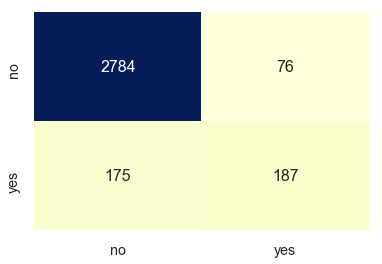

In [17]:
cm = metrics.confusion_matrix(y_train, clf.best_estimator_.predict(x_train))

df_cm = pd.DataFrame(cm, index=['no', 'yes'], columns=['no', 'yes'])

sns.heatmap(df_cm, annot=True, annot_kws={'size': 16}, cbar=False, fmt='d', cmap='YlGnBu')

**Оценим важности признаков с помощью `feature_importances_` и посмотрим повлияет ли добавление новых данных на качество модели, построив кривую обучения `learning_curve`:**

In [18]:
pd.DataFrame(zip(clf.best_estimator_.feature_importances_, train.columns[:-1]), 
             columns=['Важность', 'Признак']).sort_values(by='Важность', ascending=False)

,Важность,Признак
10,0.477763,duration
19,0.281989,nr.employed
18,0.076421,euribor3m
8,0.055402,month
12,0.032320,pdays
17,0.013424,cons.conf.idx
0,0.011904,age
16,0.011593,cons.price.idx
1,0.008127,job
11,0.007898,campaign


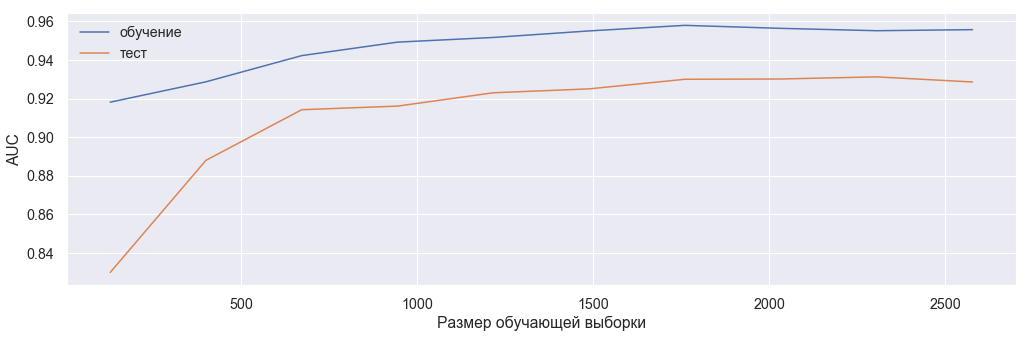

In [19]:
train_sizes = np.linspace(0.05, 1, 10)

n_train, val_train, val_test = model_selection.learning_curve(clf.best_estimator_, x_train, y_train, 
                                                              train_sizes=train_sizes, cv=5, scoring='roc_auc')

plt.figure(figsize=(17, 5))
plt.plot(n_train, val_train.mean(axis=1), label='обучение')
plt.plot(n_train, val_test.mean(axis=1), label='тест')
plt.xlabel('Размер обучающей выборки')
plt.ylabel('AUC')
plt.legend()

**Видим, что с увеличением количества объектов в обучающей выборке качество на тесте постепенно возрастает - можно предположить, что дальнейшее увеличение обучающей выборки положительно скажется на качестве модели.**

**Наконец загрузим тестовую выборку и сделаем предсказание для нее:**

In [20]:
test = pd.read_csv('test.csv')
test.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,31,blue-collar,married,high.school,no,no,no,cellular,jul,wed,248,2,999,0,nonexistent,1.4,93.918,-42.7,4.963,5228.1
1,31,blue-collar,married,basic.9y,no,yes,yes,telephone,may,wed,248,1,999,0,nonexistent,1.1,93.994,-36.4,4.859,5191.0
2,29,entrepreneur,married,high.school,no,yes,no,cellular,jul,fri,668,2,999,0,nonexistent,1.4,93.918,-42.7,4.959,5228.1
3,48,blue-collar,married,basic.4y,no,no,no,cellular,may,mon,420,7,999,1,failure,-1.8,92.893,-46.2,1.244,5099.1
4,33,admin.,married,high.school,no,yes,no,cellular,nov,tue,125,2,999,0,nonexistent,-0.1,93.200,-42.0,4.153,5195.8


In [21]:
assert [c for c in test.columns if test[c].dtype=='object'] == categorial_columns[:-1]

In [22]:
test_processed = test.copy()

for column in categorial_columns[:-1]:
    test_processed[column] = test_processed[column].map(mapping[column])

In [23]:
test_processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 897 entries, 0 to 896
Data columns (total 20 columns):
age               897 non-null int64
job               897 non-null int64
marital           897 non-null int64
education         896 non-null float64
default           896 non-null float64
housing           897 non-null int64
loan              897 non-null int64
contact           897 non-null int64
month             897 non-null int64
day_of_week       897 non-null int64
duration          897 non-null int64
campaign          897 non-null int64
pdays             897 non-null int64
previous          897 non-null int64
poutcome          897 non-null int64
emp.var.rate      897 non-null float64
cons.price.idx    897 non-null float64
cons.conf.idx     897 non-null float64
euribor3m         897 non-null float64
nr.employed       897 non-null float64
dtypes: float64(7), int64(13)
memory usage: 140.2 KB


**Видим, что в столбцах `education` и `default` есть по одному пропуску. Заполним эти пропуски значением `unknown`:**

In [24]:
test_processed.education.fillna(mapping['education']['unknown'], inplace=True)
test_processed.default.fillna(mapping['default']['unknown'], inplace=True)

In [25]:
prediction = clf.best_estimator_.predict(test_processed.values)

print('Доля согласных взять банковский продукт в тестовой выборке: {:.2f}%'.format(np.sum(prediction)/len(prediction)*100))

Доля согласных взять банковский продукт в тестовой выборке: 8.14%


**Выведем топ-5 клиентов, которые с наибольшей вероятностью согласятся взять банковский продукт:**

In [26]:
probas = clf.best_estimator_.predict_proba(test_processed.values)[:, 1]
top_probas = np.array(sorted(enumerate(probas), key=lambda x: x[1], reverse=True)[:5])

idx = top_probas[:, 0]

In [27]:
test.iloc[idx]

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
142,38,blue-collar,single,high.school,no,no,no,telephone,mar,tue,450,3,6,2,success,-1.8,93.369,-34.8,0.652,5008.7
21,45,management,married,unknown,no,yes,no,cellular,apr,tue,379,3,7,1,success,-1.8,93.749,-34.6,0.642,5008.7
214,53,blue-collar,single,basic.9y,no,unknown,unknown,cellular,mar,thu,362,1,9,2,success,-1.8,93.369,-34.8,0.643,5008.7
866,47,management,married,university.degree,no,yes,no,cellular,sep,mon,323,1,3,2,success,-3.4,92.379,-29.8,0.771,5017.5
358,26,admin.,single,university.degree,no,no,no,telephone,aug,mon,1087,1,3,1,success,-1.7,94.027,-38.3,0.904,4991.6


**В заключение попробуем ввести новые признаки и посмотрим как изменится качество предсказания случайного леса:**

In [28]:
train_extended = train.drop(['loan','default','emp.var.rate','previous','marital', 'poutcome'], axis=1)

train_extended['f1'] = train_extended.duration ** 2
train_extended['f2'] = train_extended['nr.employed'] ** 2
train_extended['f3'] = train_extended.euribor3m ** 2
train_extended['f4'] = train_extended.pdays ** 2
train_extended['f5'] = train_extended.age ** 2
train_extended['f6'] = train_extended.duration / train_extended.age
train_extended['f7'] = train_extended['nr.employed'] / train_extended.age
train_extended['f8'] = train_extended.euribor3m / train_extended.age
train_extended['f9'] = train_extended.pdays / train_extended.age
train_extended['f10'] = train_extended.duration / train_extended.euribor3m

features = ['f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10']

for f in features:
    train_extended[f] = ( train_extended[f] - train_extended[f].mean() ) / train_extended[f].std()

train_extended.head()

,age,job,education,housing,contact,month,day_of_week,duration,campaign,pdays,...,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10
0,30,0,0,0,0,0,0,487,2,999,...,0.252229,-0.914473,-1.374696,0.199193,-0.879898,1.362312,0.941369,-1.004425,0.936059,1.496869
1,39,1,1,1,1,0,0,346,4,999,...,-0.021691,0.331520,0.713981,0.199193,-0.198441,0.307402,-0.135616,0.547976,-0.001830,-0.256114
2,25,1,1,0,1,1,1,227,1,999,...,-0.180715,0.840833,0.814406,0.199193,-1.181670,0.337238,2.085150,1.970991,1.748896,-0.405408
3,38,1,0,2,1,1,0,17,3,999,...,-0.300215,0.840833,0.811560,0.199193,-0.282937,-0.899820,-0.004774,0.663613,0.080441,-0.652991
4,47,2,2,0,0,2,2,58,1,999,...,-0.293044,0.397211,0.139728,0.199193,0.556538,-0.787090,-0.794461,-0.131233,-0.533965,-0.592083


In [29]:
x_train_ext = train_extended.drop('y', axis=1).values

In [30]:
%%time
model = ensemble.RandomForestClassifier(random_state=0, verbose=0)

param_grid = {'n_estimators': [20, 50, 150], 'criterion': ['gini', 'entropy'],
              'max_depth': [None, 1, 10, 20], 'max_features': ['auto', None],
             'min_samples_leaf': [10, 15, 25], 'class_weight': ['balanced', None]}

clf = model_selection.GridSearchCV(model, param_grid, cv=skfold, scoring='roc_auc')

clf.fit(x_train_ext, y_train)

CPU times: user 18min 19s, sys: 13.4 s, total: 18min 33s
Wall time: 18min 34s


In [31]:
print('ROC AUC со случайным лесом на новых признаках: {:.3f}'.format(clf.best_score_))

ROC AUC со случайным лесом на новых признаках: 0.937


**Видим, что качество предсказания почти не изменилось - стало выше только на 0.001, что, по-видимому, связано с исключением маловажных признаков, таких как loan или default.**

**Выполнено: март 2019**